In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Edge Detection
### 1. Gradient Operators
Goal -> Identify edges as location that has high intensity changes.
There are kernels that will help us identify locations where strong intensity changes happened in both axes. We have separate kernels for separate axes. They are expressed as $G_x = \frac{\partial I}{\partial x}, \quad G_y = \frac{\partial I}{\partial y}$\
We can calculate the strength of change and the exact angle os change by using the gradients $G_x$ and $G_y$ where strength = $\sqrt{G_x^2 + G_y^2}$ and direction $theta = \tan^{-1}\left(\frac{G_y}{G_x}\right)$\
**Common Operators**
1. **Prewitt Operator**\
Simple difference between the pixels in the right and the pixels in the left column.\
X Kernel - ```[-1  0  1; -1  0  1; -1  0  1]```\
Y Kernel - ```[-1 -1 -1; 0 0 0; 1 1 1]```

2. **Sobel Operator**\
Similar to the Prewitt operator but with applies smoothing to add weights to the center pixel.\
X Kernel - ```[-1  0  1; -2  0  2; -1  0  1]```\
Y Kernel - ```[-1 -2 -1; 0 0 0; 1 2 1]```

3. **Scharr Operator**\
This is similar to the other operators but the values are different.\
X Kernel - ```[-3  0  3; -10  0  10; -3  0  3]```\
Y Kernel - ```[-3 -10 -3; 0 0 0; 3 10 3]```\

Problem - These filters are affected by noise. Even a small noise will be detected with an activation.

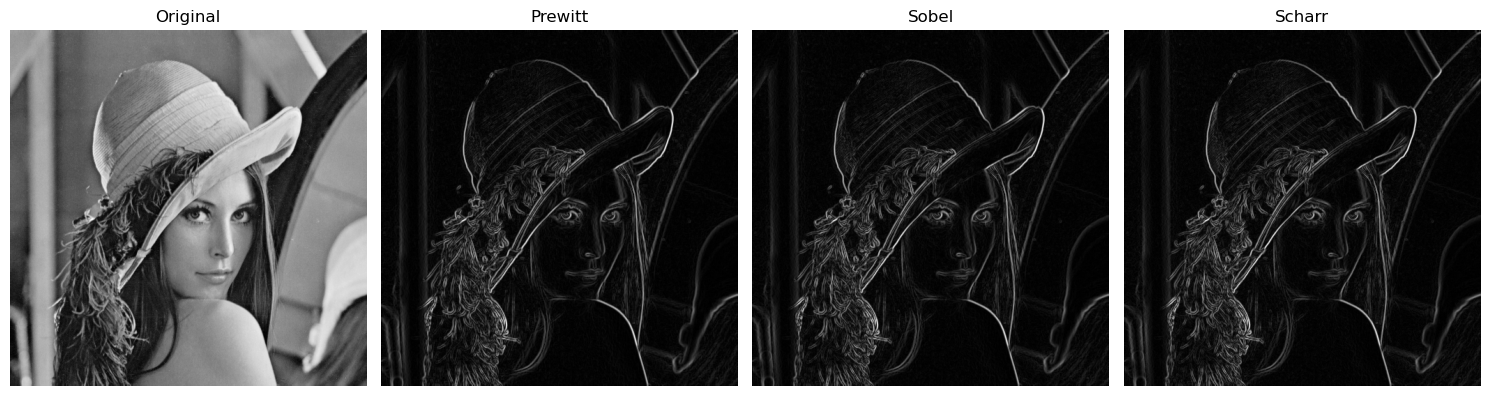

In [17]:
img = cv2.imread("images/lena.png", cv2.IMREAD_COLOR)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Prewitt
prewitt_kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
prewitt_kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)
prewittx = cv2.filter2D(img_gray, cv2.CV_64F, prewitt_kernel_x)
prewitty = cv2.filter2D(img_gray, cv2.CV_64F, prewitt_kernel_y)
prewitt = cv2.magnitude(prewittx, prewitty)

# Sobel
sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# Scharr
scharrx = cv2.Scharr(img_gray, cv2.CV_64F, 1, 0)
scharry = cv2.Scharr(img_gray, cv2.CV_64F, 0, 1)
scharr = cv2.magnitude(scharrx, scharry)

# Display
titles = ['Original', 'Prewitt', 'Sobel', 'Scharr']
images = [img_gray, prewitt, sobel, scharr]

plt.figure(figsize=(15,6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 2. Laplacian of Gaussian (LoG)
Goal -> Detect Zero-Crossing as edges. This is second derivative of Gaussian.\
**Process**\
1. Smooth the Image using Gaussian to reduce noise.
2. Apply Laplacian Operator $\nabla^2 I = \frac{\partial^2 I}{\partial x^2} + \frac{\partial^2 I}{\partial y^2}$. Edges occur where $(\nabla^2 I = 0)$. ${LoG}(x,y) = \nabla^2(G_\sigma * I)$ since the convolution operation is commutative.\

Problem - Dependency on sigma value for the gaussian blur. If the sigma value is very high then i will blur the edges hence it not be possible to detect them. If the sigma value is small the it will not be able to remove the noise.

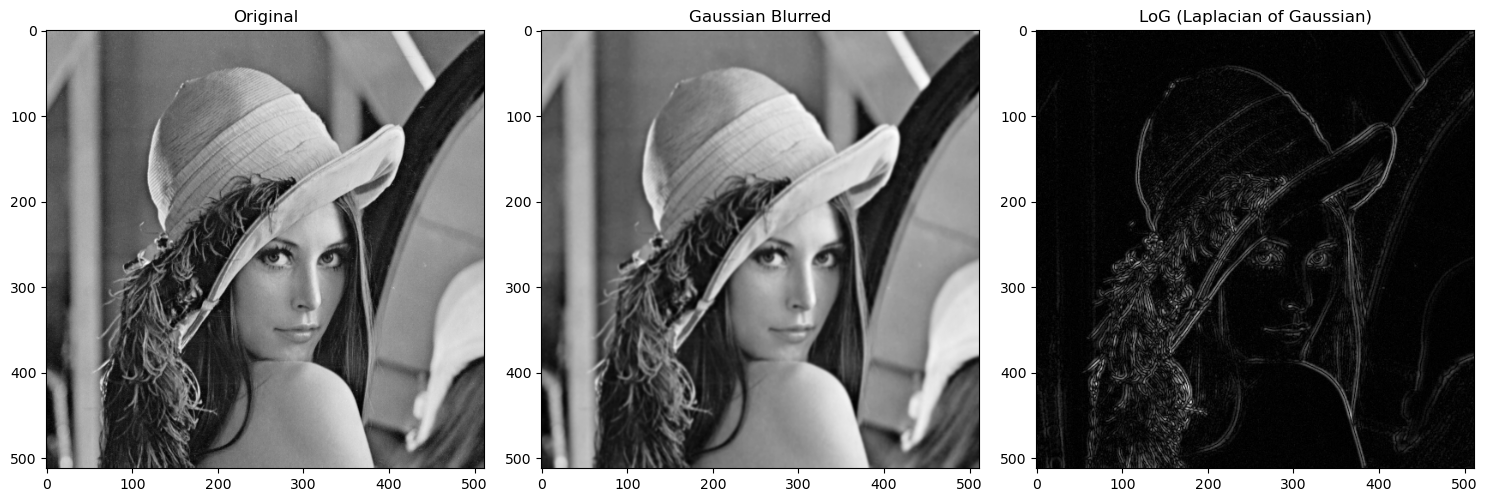

In [22]:
sigma = 1.0  
blurred = cv2.GaussianBlur(img_gray, (0, 0), sigma)
laplacian = cv2.Laplacian(blurred, cv2.CV_64F, ksize=3)
log_edges = np.uint8(np.absolute(laplacian))

zero_cross = np.zeros_like(laplacian, dtype=np.uint8)
zero_cross[np.where(np.diff(np.sign(laplacian), axis=0))] = 255
zero_cross[np.where(np.diff(np.sign(laplacian), axis=1))] = 255

plt.figure(figsize=(15,5))
plt.subplot(1,3,1), plt.imshow(img_gray, cmap='gray'), plt.title('Original')
plt.subplot(1,3,2), plt.imshow(blurred, cmap='gray'), plt.title('Gaussian Blurred')
plt.subplot(1,3,3), plt.imshow(log_edges, cmap='gray'), plt.title('LoG (Laplacian of Gaussian)')
plt.tight_layout()
plt.show()

### **3️⃣ Canny Edge Detection**
Canny is one of the most powerful edge detectors — it can identify even very **fine and faint edges** while maintaining clean, continuous boundaries.
#### **Process**
1. **Gaussian Smoothing**  
   Reduce noise by convolving the image with a Gaussian filter.
   $I_s = G_\sigma * I$
2. **Gradient Computation (using Sobel Filters)**  
   Compute the gradient magnitude and direction:
   $G_x, G_y \quad \Rightarrow \quad 
   G = \sqrt{G_x^2 + G_y^2}, \quad 
   \theta = \tan^{-1}\left(\frac{G_y}{G_x}\right)$
3. **Non-Maximum Suppression**  
   Retain only the local maxima (strongest edge responses) to thin out edges. This removes unwanted spatial noise and keeps edges sharp.
   - Slide a 3×3 kernel across the image.  
   - Compare the center pixel with its two neighbors along the gradient direction.  
   - If it’s the maximum, keep it; otherwise, set it to 0.
4. **Hysteresis Thresholding (Edge Linking)**  
   Ensures edge connectivity while discarding isolated noise. This step ensures thin, connected, and clean edge maps.
   - Apply **double thresholding**:
     - High threshold → **strong edges**
     - Low threshold → **weak edges**
     - Below low threshold → **discarded as noise**
   - For each strong edge pixel, check its 8-neighbors:
     - If a weak edge pixel is connected, promote it to a strong edge.

In [ ]:
canny_eddges = cv2.Canny(img_gray, 100, 200)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1), plt.imshow(img_gray, cmap='gray'), plt.title('Original')
plt.subplot(1,2,2), plt.imshow(canny, cmap='gray'), plt.title('Canny Edge')
plt.tight_layout()
plt.show()